In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.color_palette("light:darkblue", as_cmap=True)

In [2]:
## load data for subplot A and D#

#dataframe with pi_inital and resident propensity from stability simulation  
pinew_pires_stability = pd.read_csv("../data/1qhw_paired_pinew_pires_0_500.csv")

#discretize pi_initial values 
bins = np.arange(0, 1.0+0.05, 0.201)
ind = np.digitize(pinew_pires_stability["pi_initial"], bins)
pinew_pires_stability["range"] = ind

data_melted = pd.melt(pinew_pires_stability, id_vars = "range", value_vars=['pi_initial', 'propensity'])
data_melted = data_melted.drop_duplicates()

propensities = data_melted[data_melted["variable"] == "propensity"]["value"]
pi_intial = data_melted[data_melted["variable"] == "pi_initial"]["value"]

In [3]:
## load data for subplot B#
qhw_rst = pd.read_csv("../data/conc_data_1qhw_Ne2_nsubs_5e2_0_500.csv")
null_emp_df = pd.read_csv("../data/null_model_empirical_distribution.csv")

avg_pi_sim = qhw_rst["avg_pi_res"]
avg_pi_null = null_emp_df["AVG_pi"]

In [4]:
## load data for subplot C # 
pi_ono = np.load("../data/pi_old_new_other_0_500.npy")  # [pi_old, pi_new, pi_1, pi_2, ..., pi_20]

pi_old = pi_ono[:,0] # first column is the propensity for previous aa (pi_old)
pi_new = pi_ono[:,1] # second column is the propensity for the new aa (pi_new)
pi_other = pi_ono[:,2:] # last columns are the 20 propensity landscape

# null distribution
rndm = np.zeros((10000, len(pi_old)))
for i in range(len(pi_old)):
    rndm_i = np.random.choice(pi_other[i], 10000)
    rndm[:,i] = rndm_i
r_null = [stats.pearsonr(pi_old, rndm[i])[0] for i in range(10000)]

r_sim, p_sim = stats.pearsonr(pi_old, pi_new)

In [5]:
# data for subplot E # 
ind_null = np.digitize(null_emp_df["pi_initial"], bins)
null_emp_df["range"] = ind_null

ind_sim = np.digitize(qhw_rst["pi_initial"], bins)
qhw_rst["range"] = ind_sim

# group based on pi_intial and output mean and std
group = qhw_rst.groupby("range").agg([np.mean, np.std])["M_AMI"]
group["range"] = [0,1,2,3,4]

group_null = null_emp_df.groupby("range").agg([np.mean, np.std])["M_AMI"]
group_null["range"] = [0.1,1.1,2.1,3.1,4.1]

Text(-0.5, 1.05, 'E')

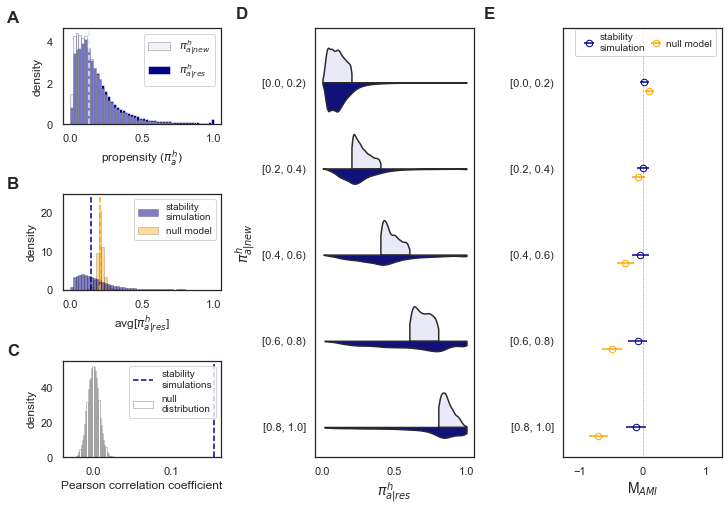

In [6]:
b = np.arange(0, 1.00  + 0.02, 0.02)

f = plt.figure(constrained_layout=True, figsize = (10,7))
gs = f.add_gridspec(3, 3)

## SUBPLOT A ## 
#histogram of pi_new and pi_res
ax1 = f.add_subplot(gs[0, 0])
ax1.hist(list(set(pi_intial)), color = "lavender", bins = b, edgecolor='k' , 
        linewidth=0.5, stacked = True, alpha = 0.5, density = True, zorder = 1, label = "$\pi^h_{a|new}$")
ax1.hist(propensities, color = 'darkblue', bins = b, edgecolor='w' , 
        linewidth=0.5, stacked = True, density = True, zorder = 0, label = "$\pi^h_{a|res}$")
ax1.legend()
ax1.axvline(np.median(list(set(pi_intial))), linestyle = "--", color = "lavender")

## SUBPLOT B ## 
#histogram of avg propensities
ax2 = f.add_subplot(gs[1, 0])
ax2.hist(avg_pi_sim, color = "darkblue", bins = b, edgecolor='k' , 
     linewidth=0.5, stacked = True, alpha = 0.5, density = True, zorder = 1, label = "stability\nsimulation")
ax2.hist(avg_pi_null, color = 'orange', bins = b, edgecolor='k' , 
     linewidth=0.5, stacked = True, density = True, alpha = 0.4, zorder = 0, label = "null model")
ax2.legend(fontsize = 10)
ax2.axvline(np.median(avg_pi_sim), linestyle = "--", color = "darkblue")
ax2.axvline(np.median(avg_pi_null), linestyle = "--", color = "orange")


## SUBPLOT C ## 
ax3 = f.add_subplot(gs[2, 0])
ax3.hist(r_null, color = "w", bins = 40, edgecolor='k' , 
     linewidth=0.5, alpha = 0.5, density = True, label = "null\ndistribution")
ax3.axvline(r_sim, linestyle = "--", color = "darkblue", label = "stability\nsimulations")
ax3.legend(fontsize = 10)


## SUBPLOT D ## 
# violin plots of pi_new and pi_res
ax4 = f.add_subplot(gs[:, 1])
sns.violinplot(x="value", y="range", hue = "variable", data= data_melted, split = True,
               kind="violin", orient ='h', alpha =0.2, inner = None, cut=0,
               palette = ["lavender", "darkblue"], ax = ax4)
ax4.get_legend().set_visible(False)


## SUBPLOT E ## 
ax5 = f.add_subplot(gs[:, 2], sharey = ax4)
ax5.errorbar(group["mean"], group["range"], xerr = group["std"], color = 'darkblue', marker = 'o', 
                mec = 'darkblue', mfc = 'None', mew = 1, ms = 6.5 , fmt = '.', zorder = 0, label = "stability\nsimulation")
ax5.errorbar(group_null["mean"], group_null["range"], xerr = group["std"], color = 'orange', marker = 'o', 
                mec = 'orange', mfc = 'None', mew = 1, ms = 6.5, fmt = '.', zorder = 0, label = "null model")
ax5.legend(loc='upper left', fontsize = 10, handletextpad=0.05, columnspacing = 0.1, ncol = 2, bbox_to_anchor=(0.04, 1.01))
ax5.axvline(0, linestyle = ":", linewidth = 0.5, c = "k")


# axis lables
ax1.set_ylabel("density", fontsize = 12)
ax1.set_xlabel("propensity ($\pi_a^h$)")

ax2.set_ylabel("density", fontsize = 12)
ax2.set_xlabel("avg[$\pi_{a|res}^h$]")

ax3.set_ylabel("density", fontsize = 12)
ax3.set_xlabel("Pearson correlation coefficient")

ax4.set_ylabel("$\pi^h_{a|new}$" , fontsize = 14)
ax4.set_xlabel("$\pi^h_{a|res}$", fontsize = 14)

ax5.set_ylabel("")
ax5.set_xlabel("M$_{AMI}$", fontsize = 14)


# axis limits and tick labels
ax2.set_ylim(0, 25)
ax5.set_yticklabels(["[0.0, 0.2)", "[0.2, 0.4)", "[0.4, 0.6)", "[0.6, 0.8)", "[0.8, 1.0]"])
ax5.set_xlim(-1.25, 1.25)

#subplot labels 
ax1.text(-0.35, 1.18, "A", transform=ax1.transAxes, fontsize=17, fontweight='bold', va='top')
ax2.text(-0.35, 1.18, "B", transform=ax2.transAxes, fontsize=17, fontweight='bold', va='top')
ax3.text(-0.35, 1.18, "C", transform=ax3.transAxes, fontsize=17, fontweight='bold', va='top')
ax4.text(-0.5, 1.05, "D", transform=ax4.transAxes, fontsize=17, fontweight='bold', va='top')
ax5.text(-0.5, 1.05, "E", transform=ax5.transAxes, fontsize=17, fontweight='bold', va='top')


#plt.savefig('../figures/Figure3_fin.png', dpi = 450)